In [12]:
!pip install umap-learn


/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Choosing from all possible events


Loading data...


/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 48 events (all good), 2 – 6 s (baseline off), ~8.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12
 'feet': 12
 'tongue': 12>
  warn(f"warnEpochs {epochs}")
/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 48 events (all good), 2 – 6 s (baseline off), ~8.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12
 'feet': 12
 'tongue': 12>
  warn(f"warnEpochs {epochs}")
/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 48 events (all good), 2 – 6 s (baseline off), ~8.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12
 'feet': 12
 'tongue': 12>
  warn(f"warnEpochs {epochs}")
/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: Use

X shape: (1152, 22, 1001)
y shape: (1152,)
meta shape: (1152, 3)
Source shape: (576, 22, 1001)
Target shape: (576, 22, 1001)
Computing covariance matrices...
Visualizing original embeddings...


/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


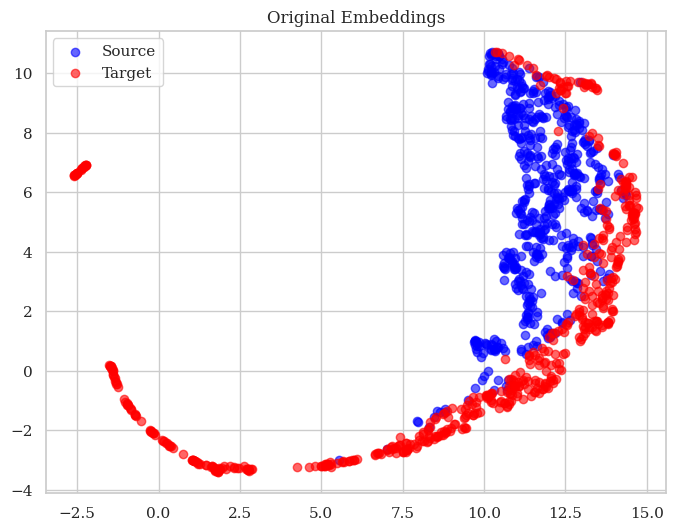

Applying MEKT transformation...
Visualizing MEKT transformed embeddings...


/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


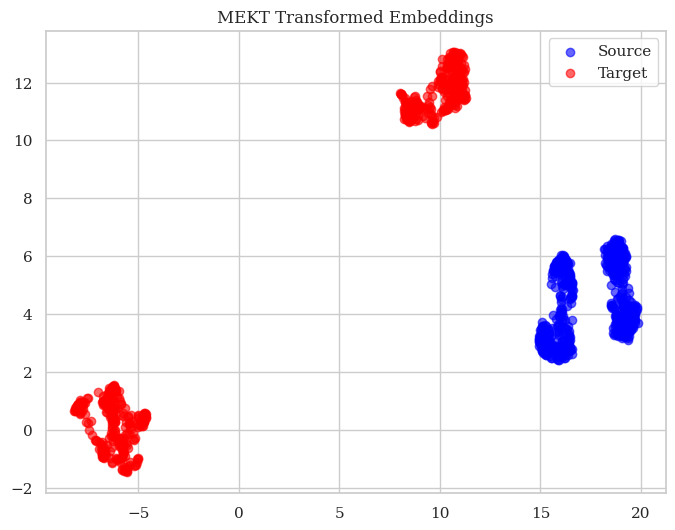

MEKT transform shapes:
Source: (576, 253)
Target: (576, 253)


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from moabb.datasets import BNCI2014_001 
from moabb.paradigms import MotorImagery
from scipy.linalg import sqrtm, logm, expm
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

# ------------------------------------------------------
# Riemannian geometry helper functions
# ------------------------------------------------------
def riemann_mean(covmats, max_iter=50, tol=1e-6):
    """Compute the Riemannian mean of SPD matrices."""
    n_matrices = len(covmats)
    mean = covmats[0].copy()
    for _ in range(max_iter):
        prev_mean = mean.copy()
        sum_logs = np.zeros_like(mean)
        inv_mean = np.linalg.inv(mean)
        for c in covmats:
            sum_logs += logm(inv_mean @ c)
        mean = mean @ expm(sum_logs / n_matrices)
        if np.linalg.norm(mean - prev_mean) < tol:
            break
    return mean

def align_covariance_matrices(covmats, reference):
    """Align SPD matrices to a reference on the Riemannian manifold."""
    aligned = []
    ref_sqrt = sqrtm(reference)
    ref_sqrt_inv = np.linalg.inv(ref_sqrt)
    for c in covmats:
        aligned.append(ref_sqrt_inv @ c @ ref_sqrt_inv)
    return np.array(aligned)

def tangent_space_mapping(aligned_covmats):
    """Log-map aligned SPD matrices to the tangent space."""
    n = len(aligned_covmats)
    n_channels = aligned_covmats[0].shape[0]
    out_dim = n_channels * (n_channels + 1) // 2
    ts = np.zeros((n, out_dim))
    inds = np.triu_indices(n_channels)
    for i, c in enumerate(aligned_covmats):
        log_c = logm(c)
        ts[i] = log_c[inds]
    return ts

# ------------------------------------------------------
# Data loading and covariance computation
# ------------------------------------------------------
def load_mi_data(subjects=[1,2]):
    """
    Loads motor imagery data from BNCI2014_001 using MOABB
    and concatenates all metadata into a single DataFrame.
    """
    dataset = BNCI2014_001()
    paradigm = MotorImagery(n_classes=2)
    X_list = []
    y_list = []
    meta_list = []
    
    for subj in subjects:
        X_subj, y_subj, meta_subj = paradigm.get_data(dataset=dataset, subjects=[subj])
        X_list.append(X_subj)
        y_list.append(y_subj)
        # meta_subj is a DataFrame, store for later concatenation
        meta_list.append(meta_subj)
    
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    # Concatenate all metadata DataFrames so it has same length as X
    meta = pd.concat(meta_list, ignore_index=True)
    return X, y, meta

def compute_covariance_matrices(X):
    """Compute trial-by-trial covariance matrices."""
    n_trials = X.shape[0]
    n_channels = X.shape[1]
    covmats = np.zeros((n_trials, n_channels, n_channels))
    for i in range(n_trials):
        covmats[i] = np.cov(X[i])
    return covmats

# ------------------------------------------------------
# MEKT domain adaptation
# ------------------------------------------------------
def mekt_transform(source_cov, target_cov, alpha=0.01, beta=0.1, rho=20):
    """
    Apply a simplified MEKT-like transform:
    1) Compute Riemannian mean on combined covariances
    2) Align source and target
    3) Log-map to tangent space
    4) Standardize
    """
    combined = np.concatenate([source_cov, target_cov])
    reference = riemann_mean(combined)
    aligned_src = align_covariance_matrices(source_cov, reference)
    aligned_tgt = align_covariance_matrices(target_cov, reference)
    
    src_ts = tangent_space_mapping(aligned_src)
    tgt_ts = tangent_space_mapping(aligned_tgt)
    
    scaler = StandardScaler()
    src_ts = scaler.fit_transform(src_ts)
    tgt_ts = scaler.transform(tgt_ts)
    
    return src_ts, tgt_ts

# ------------------------------------------------------
# Embedding visualization
# ------------------------------------------------------
def visualize_embeddings(src_data, tgt_data, title):
    """
    Visualize embeddings with UMAP. 
    Source in blue, target in red.
    """
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    combined = np.vstack([src_data, tgt_data])
    emb = reducer.fit_transform(combined)
    
    n_source = len(src_data)
    plt.figure(figsize=(8,6))
    plt.scatter(emb[:n_source,0], emb[:n_source,1], c='blue', alpha=0.6, label='Source')
    plt.scatter(emb[n_source:,0], emb[n_source:,1], c='red', alpha=0.6, label='Target')
    plt.title(title)
    plt.legend()
    plt.show()

# ------------------------------------------------------
# Main script
# ------------------------------------------------------
def main():
    print("Loading data...")
    X, y, meta = load_mi_data(subjects=[1,2])
    
    # We have a single DataFrame meta, whose length matches X.shape[0]
    # Separate the trials for subject=1 and subject=2
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    print("meta shape:", meta.shape)
    
    source_idx = meta['subject'] == 1
    target_idx = meta['subject'] == 2
    
    X_source = X[source_idx]
    y_source = y[source_idx]
    X_target = X[target_idx]
    
    print("Source shape:", X_source.shape)
    print("Target shape:", X_target.shape)
    
    # Convert to covariance matrices
    print("Computing covariance matrices...")
    source_cov = compute_covariance_matrices(X_source)
    target_cov = compute_covariance_matrices(X_target)
    
    # Visualize original embeddings by just flattening
    print("Visualizing original embeddings...")
    src_flat = source_cov.reshape(source_cov.shape[0], -1)
    tgt_flat = target_cov.reshape(target_cov.shape[0], -1)
    visualize_embeddings(src_flat, tgt_flat, "Original Embeddings")
    
    # Apply MEKT transform
    print("Applying MEKT transformation...")
    src_ts, tgt_ts = mekt_transform(source_cov, target_cov)
    
    # Visualize after transformation
    print("Visualizing MEKT transformed embeddings...")
    visualize_embeddings(src_ts, tgt_ts, "MEKT Transformed Embeddings")
    
    # Simple LDA training on source -> evaluate shape
    clf = LinearDiscriminantAnalysis()
    clf.fit(src_ts, y_source)
    
    print("MEKT transform shapes:")
    print("Source:", src_ts.shape)
    print("Target:", tgt_ts.shape)

if __name__ == "__main__":
    main()
